### IMPORT PACKAGES

In [1]:
import os
import time
import pandas as pd
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait as WDW
from selenium.webdriver.support import expected_conditions as EC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install torch --use-feature=2020-resolver
from underthesea import word_tokenize
from xlrd import open_workbook
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
print(os.path.exists('./chromedriver.exe'))  # True nếu đúng

True


### TASK 1: COLLECTING DATA

#### 1.1 Functions to Get data from 3 Youtube Videos (Khoa Pug)

In [3]:
# Create ChromeDriver to executable that Selenium WebDriver uses to control Chrome
def ChromeDriver(url,t):
    data = []
    service = Service(executable_path=r'D:\hoctrentruong\DAT\project\Emotion-Regconition-Youtube-main\Emotion-Regconition-Youtube-main/chromedriver.exe')
    with Chrome(service=service) as ChD:
        wait = WDW(ChD,t)
        ChD.get(url)
        for item in range(101): 
            wait.until(EC.visibility_of_element_located((By.TAG_NAME, "body"))).send_keys(Keys.END)
            time.sleep(t)
        for comment in wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#content"))):
            if(len(str(comment.text))>10): # Do not accept short comment or doesn't mean much
                data.append(comment.text)
            if(len(data)==103): # 100 comments + 3(title,description,first comment of Khoa Pug)
                break
    return data

def getData_Video(url,t):
    data = ChromeDriver(url,t)
    while(len(data)==103):
        for i in range(3): # Remove 3(title,description,first comment of Khoa Pug)
            data.pop(0)
        print("Success!! Crawled 100 comments from Video [" + url.split("v=")[1] + "]!")
        return data
    print("Failed!! Please try again.")
    return data

#### 1.2 Choose 3 Videos and Make storageDir

In [4]:
url1 = "https://www.youtube.com/watch?v=hassqXTvsXM"
url2 = "https://www.youtube.com/watch?v=RG-dXrbRNuw"
url3 = "https://www.youtube.com/watch?v=ipSpPzFqNH0"

storageDir = "dataList/"
if not os.path.exists(storageDir):
    os.makedirs(storageDir)

#### 1.3 Crawling 100 comments

In [5]:
data1 = getData_Video(url1,0.035)

Success!! Crawled 100 comments from Video [hassqXTvsXM]!


In [6]:
data2 = getData_Video(url2,0.040)

Success!! Crawled 100 comments from Video [RG-dXrbRNuw]!


In [8]:
data3 = getData_Video(url3,0.025)

Success!! Crawled 100 comments from Video [ipSpPzFqNH0]!


#### 1.4 Label these comments by yourself in 7 classes

In [9]:
DG = "Disgust"
EJ = "Enjoyment"
AG = "Anger"
SP = "Surprise"
SN = "Sadness"
FE = "Fear"
OT = "Other"

emotion1 = [
    OT,EJ,EJ,OT,OT,SN,SN,OT,EJ,EJ,
    SP,EJ,EJ,OT,OT,OT,EJ,OT,EJ,EJ,
    SP,EJ,EJ,OT,SP,OT,EJ,EJ,EJ,OT,
    EJ,EJ,EJ,OT,OT,OT,SN,OT,EJ,DG,
    EJ,EJ,EJ,EJ,EJ,EJ,OT,OT,EJ,EJ,
    EJ,FE,EJ,OT,OT,OT,EJ,OT,EJ,OT,
    OT,SP,SP,OT,OT,EJ,EJ,OT,EJ,EJ,
    DG,SP,AG,OT,OT,EJ,OT,SN,EJ,EJ,
    OT,EJ,EJ,EJ,OT,EJ,OT,FE,EJ,EJ,
    EJ,OT,OT,SP,OT,OT,DG,OT,EJ,OT
]
emotion2 = [
    OT,EJ,SN,EJ,SP,OT,OT,FE,OT,EJ,
    SP,EJ,EJ,AG,OT,OT,SN,EJ,OT,OT,
    OT,EJ,SN,EJ,EJ,DG,OT,OT,EJ,EJ,
    EJ,EJ,EJ,SN,OT,OT,EJ,EJ,EJ,OT,
    SN,OT,EJ,EJ,EJ,EJ,OT,EJ,OT,OT,
    OT,OT,EJ,EJ,OT,OT,EJ,OT,OT,OT,
    OT,EJ,EJ,EJ,EJ,EJ,OT,OT,EJ,EJ,
    EJ,OT,OT,OT,OT,SN,OT,EJ,EJ,EJ,
    OT,OT,EJ,OT,OT,EJ,EJ,SP,FE,OT,
    OT,OT,EJ,OT,OT,EJ,OT,OT,OT,EJ
]
emotion3 = [
    OT,OT,EJ,OT,OT,EJ,OT,EJ,FE,FE,
    EJ,EJ,SP,SP,SN,OT,EJ,OT,OT,EJ,
    EJ,FE,SN,EJ,OT,OT,EJ,EJ,FE,EJ,
    SN,EJ,EJ,OT,EJ,FE,SN,OT,EJ,OT,
    SN,EJ,EJ,SN,EJ,EJ,SN,OT,EJ,EJ,
    OT,FE,SN,AG,OT,OT,EJ,OT,EJ,OT,
    OT,SP,SP,OT,SN,EJ,EJ,SN,OT,OT,
    SP,SP,EJ,OT,OT,EJ,OT,OT,DG,SN,
    OT,AG,EJ,EJ,OT,SN,SP,FE,SN,EJ,
    EJ,EJ,EJ,OT,OT,SP,FE,SP,EJ,FE
]

#### 1.5 Write data to CSV

In [10]:
dataList1 = {"Emotion": emotion1, "Sentence": data1}

df1 = pd.DataFrame(dataList1)
df1.to_csv(storageDir + "dataList1.csv", encoding = "utf-8-sig")
df1.head()

,Emotion,Sentence
0,Other,thích nhất cái khoản anh Khoa đi đâu cũng giới...
1,Enjoyment,Hay quá Khoa ơi nhiều người như Em sẽ làm ngườ...
2,Enjoyment,Khuôn mặt thân thiện hiền lành vui vẽ. ..làm đ...
3,Other,"Chào Khoa, mỗi clip Khoa đăng lên Cô rất vui k..."
4,Other,"""...đồ ăn Việt Nam vẫn là ngon nhất..."" ủng hộ..."


In [11]:
dataList2 = {"Emotion": emotion2, "Sentence": data2}

df2 = pd.DataFrame(dataList2)
df2.to_csv(storageDir + "dataList2.csv", encoding = "utf-8-sig")
df2.head()

,Emotion,Sentence
0,Other,T mắc cười khúc đầu bếp chào xong cái ông Khoa...
1,Enjoyment,Review về Dubai đi anh Khoa. Ai đồng ý xin 1 l...
2,Sadness,ăn không biết sao mà nhìn họ làm thấy ngon quá...
3,Enjoyment,"Ăn ở VN cũng rất ngon, giúp xứ sở, dân mình c..."
4,Surprise,Coi vd mà không ai khen anh đầu bếp vậy ta. Mì...


In [12]:
dataList3 = {"Emotion": emotion3, "Sentence": data3}

df3 = pd.DataFrame(dataList3)
df3.to_csv(storageDir + "dataList3.csv", encoding = "utf-8-sig")
df3.head()

,Emotion,Sentence
0,Other,"Xem những hình ảnh này, rồi cả những gì họ hứn..."
1,Other,"ở ấn độ có người nhiễm cúm corona rồi đó, ko t..."
2,Enjoyment,"Khoa có hai cô bạn thật dễ thương, cô nào cũng..."
3,Other,Người ta đi review du lịch đi những nơi cao sa...
4,Other,Cám ơn Khoa và Cameraman đã không ngại khổ mà ...


#### 1.6 Read data from CSV

In [13]:
dataList1 = pd.read_csv(storageDir + "dataList1.csv", encoding = "utf8")
dataList2 = pd.read_csv(storageDir + "dataList2.csv", encoding = "utf8")
dataList3 = pd.read_csv(storageDir + "dataList3.csv", encoding = "utf8")

#### 1.7 Remove redundant attributes

In [14]:
dataList1.pop("Unnamed: 0")
dataList2.pop("Unnamed: 0")
dataList3.pop("Unnamed: 0")

0      0
1      1
2      2
3      3
4      4
      ..
95    95
96    96
97    97
98    98
99    99
Name: Unnamed: 0, Length: 100, dtype: int64

#### 1.8 Add column length of sentence

In [15]:
lengthDataList1 = []
lengthDataList2 = []
lengthDataList3 = []
for i in range(100):
    lengthDataList1.append(len(dataList1.Sentence[i]))
    lengthDataList2.append(len(dataList2.Sentence[i]))
    lengthDataList3.append(len(dataList3.Sentence[i]))

dataList1["Length"] = lengthDataList1
dataList2["Length"] = lengthDataList2
dataList3["Length"] = lengthDataList3

dataList1.head()

,Emotion,Sentence,Length
0,Other,thích nhất cái khoản anh Khoa đi đâu cũng giới...,163
1,Enjoyment,Hay quá Khoa ơi nhiều người như Em sẽ làm ngườ...,76
2,Enjoyment,Khuôn mặt thân thiện hiền lành vui vẽ. ..làm đ...,197
3,Other,"Chào Khoa, mỗi clip Khoa đăng lên Cô rất vui k...",122
4,Other,"""...đồ ăn Việt Nam vẫn là ngon nhất..."" ủng hộ...",71


In [16]:
dataList2.head()

,Emotion,Sentence,Length
0,Other,T mắc cười khúc đầu bếp chào xong cái ông Khoa...,99
1,Enjoyment,Review về Dubai đi anh Khoa. Ai đồng ý xin 1 l...,71
2,Sadness,ăn không biết sao mà nhìn họ làm thấy ngon quá...,85
3,Enjoyment,"Ăn ở VN cũng rất ngon, giúp xứ sở, dân mình c...",57
4,Surprise,Coi vd mà không ai khen anh đầu bếp vậy ta. Mì...,132


In [17]:
dataList3.head()

,Emotion,Sentence,Length
0,Other,"Xem những hình ảnh này, rồi cả những gì họ hứn...",218
1,Other,"ở ấn độ có người nhiễm cúm corona rồi đó, ko t...",150
2,Enjoyment,"Khoa có hai cô bạn thật dễ thương, cô nào cũng...",246
3,Other,Người ta đi review du lịch đi những nơi cao sa...,421
4,Other,Cám ơn Khoa và Cameraman đã không ngại khổ mà ...,271


#### 1.9 Show Histogram Graph & Pie Chart

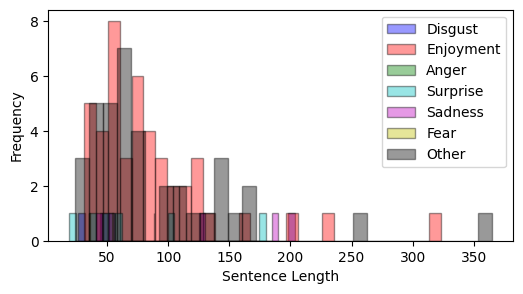

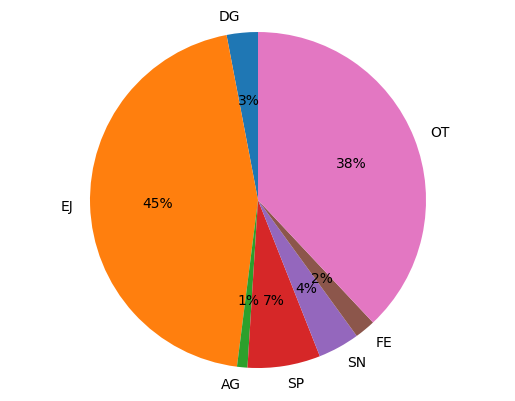

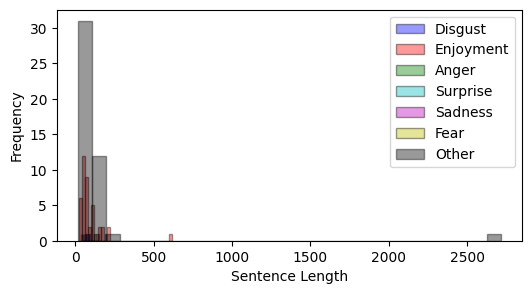

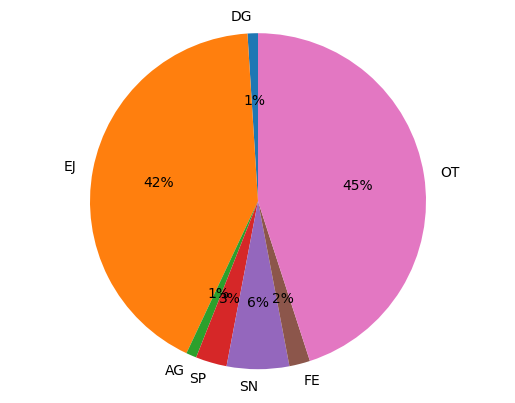

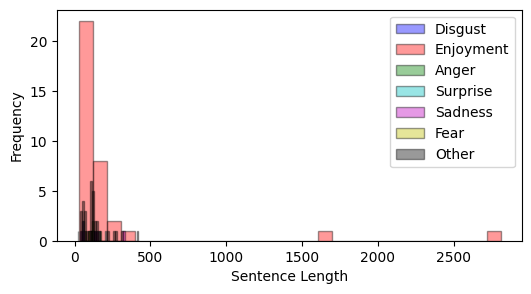

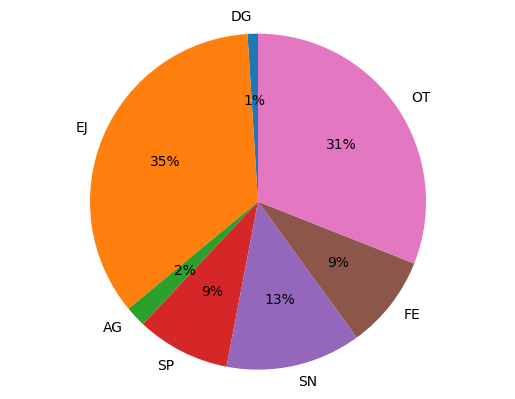

In [18]:
def Show_HistGraph_And_PieChart(dataList):
    E_DG = dataList.loc[dataList.Emotion == DG, 'Length']
    E_EJ = dataList.loc[dataList.Emotion == EJ, 'Length']
    E_AG = dataList.loc[dataList.Emotion == AG, 'Length']
    E_SP = dataList.loc[dataList.Emotion == SP, 'Length']
    E_SN = dataList.loc[dataList.Emotion == SN, 'Length']
    E_FE = dataList.loc[dataList.Emotion == FE, 'Length']
    E_OT = dataList.loc[dataList.Emotion == OT, 'Length']
    
    # Histogram Graph
    config = dict(alpha=0.4, bins=30, edgecolor = "black")
    plt.figure(figsize=(6,3))
    plt.hist(E_DG, **config, color = 'b', label = 'Disgust')
    plt.hist(E_EJ, **config, color = 'r', label = 'Enjoyment')
    plt.hist(E_AG, **config, color = 'g', label = 'Anger')
    plt.hist(E_SP, **config, color = 'c', label = 'Surprise')
    plt.hist(E_SN, **config, color = 'm', label = 'Sadness')
    plt.hist(E_FE, **config, color = 'y', label = 'Fear')
    plt.hist(E_OT, **config, color = 'k', label = 'Other')
    plt.ylabel('Frequency')
    plt.xlabel('Sentence Length')
    plt.legend();
    
    # Pie Chart
    Pie = [len(E_DG),len(E_EJ),len(E_AG),len(E_SP),len(E_SN),len(E_FE),len(E_OT)]
    f, Ax = plt.subplots()
    Ax.pie(Pie, labels=['DG','EJ','AG','SP','SN','FE','OT'], autopct='%1.0f%%', startangle=90)
    Ax.axis('equal')

Show_HistGraph_And_PieChart(dataList1)
Show_HistGraph_And_PieChart(dataList2)
Show_HistGraph_And_PieChart(dataList3)

### TASK 2: EMOTION RECOGNITION FOR VIETNAMESE SOCIAL MEDIA TEXT

#### 2.1 Read data from UIT-VSMEC

In [19]:
dataTrainUIT = pd.read_excel("UIT-VSMEC/train_nor_811.xlsx", engine='openpyxl')
dataValidUIT = pd.read_excel("UIT-VSMEC/valid_nor_811.xlsx", engine='openpyxl')
data_TestUIT = pd.read_excel("UIT-VSMEC/test_nor_811.xlsx", engine='openpyxl')

# Model
model = DecisionTreeClassifier()

# Y
trainY = dataTrainUIT.Emotion
validY = dataValidUIT.Emotion
testY  = data_TestUIT.Emotion

#### 2.2 Text preprocess (stopword, word segmentation, learn vocabulary and idf)

In [20]:
def text_process(datasets):
    # Stopwords
    StopWords = [
        'chs','cerrrr','aaaaa','aaaaaaa','aamir','abcxyz','ac','18','200','500','dek','thg','đg','đs','đm','đuma',
        'vl','vcl','kkk','dcm','cu','ừm','đĩ','đụ','địt','xl','lol','01','10','100', '11','12','13','14','15','150',
        '17','1700''1967','20','21','22','225','23','24','25','26','28','2_','2_3','30','300','3000','320','333',
        '33333','40','400','42','45','48', '50','5000','580','60','63','66','75','78','80','800','81','850','90','900',
        '99','99999','_200','_5','ah','bn','c3','chg','cp','dòg','hlin','lòn','lôz','tđ','đkm','đkmm','đmaaaa','đmm',
        'đmmmmm','đỹ','vcb','vclll','đụ_mẹ','trươ','trưen','amir','ga','1700','1967','bg','chaiii','clm','cmm','cmnl','cã',
        'hloz','imdb','kau','kbh','loz','lozzz','lozzzz','matlon','muô','nh','nhma','p30','16','250','56','adm','ngươ'
    ]
    Tfidf = TfidfVectorizer(stop_words = StopWords)
    
    # Word Segmentation
    WordSeg = []
    for i in range(datasets.shape[0]):
        sentence_strip = datasets.Sentence[i].strip() # Remove spaces at begin & end
        WordSeg.append(word_tokenize(sentence_strip, format='text')) # format text: add "_" where text is phrases.
    datasets.Sentence = WordSeg # Update new sentences
    
    # Learn vocabulary and idf.
    X = Tfidf.fit_transform(datasets.Sentence)
    # Display after processing
    print(Tfidf.get_feature_names_out()); print("\n\n")
    # return document-term matrix after processing
    return X



#### 2.3 Using Train&Valid sets of UIT-VSMEC for training Emotion Recognition model

In [21]:
trainY = dataTrainUIT["Emotion"]
validY = dataValidUIT["Emotion"]

trainValidX = pd.concat([dataTrainUIT, dataValidUIT]).reset_index(drop=True)
trainValidX = text_process(trainValidX)
trainValidY = pd.concat([trainY, validY]).reset_index(drop=True)

trainX, testX, trainY, testY = train_test_split(trainValidX, trainValidY, test_size=0.33, random_state=42)
model = model.fit(trainX, trainY)
predY = model.predict(testX)


['2000' '2012' '2015' ... 'ức_chế' 'ứng' 'ứng_dụng']





#### 2.3 Performance metrics (Accuracy, F1-score…) for the test sets in UIT-VSMEC

In [22]:
Accuracy  = []
Precision = []
F1_Score  = []

Accuracy.append(accuracy_score(testY, predY))
F1_Score.append(f1_score(testY, predY, average='weighted'))  # Could change to None,'weighted','micro','macro'
Precision.append(precision_score(testY, predY, average='weighted'))

averageAccuracy = sum(Accuracy)/len(Accuracy)
print("Average of Accuracy:", averageAccuracy)
averageF1_Score = sum(F1_Score)/len(F1_Score)
print("Average of F1_Score:", averageF1_Score)
averagePrecision = sum(Precision)/len(Precision)
print("Average of Precision:", averagePrecision)

Average of Accuracy: 0.35374149659863946
Average of F1_Score: 0.3522830576160995
Average of Precision: 0.35332232471954433


### TASK 3: APPLYING THE TRAINED MODEL IN TASK 2 TO THREE DATASETS IN TASK 1

#### 3.1 Applying the trained model in Task 2 to three datasets in Task 1

In [23]:
dataListY1 = dataList1.Emotion
dataListY2 = dataList2.Emotion
dataListY3 = dataList3.Emotion

dataListX1 = text_process(dataList1)
trainX1, testX1, trainY1, testY1 = train_test_split(dataListX1, dataListY1, test_size=0.33, random_state=42)
model = model.fit(trainX1, trainY1)
predY1 = model.predict(testX1)

dataListX2 = text_process(dataList2)
trainX2, testX2, trainY2, testY2 = train_test_split(dataListX2, dataListY2, test_size=0.33, random_state=42)
model = model.fit(trainX2, trainY2)
predY2 = model.predict(testX2)

dataListX3 = text_process(dataList3)
trainX3, testX3, trainY3, testY3 = train_test_split(dataListX3, dataListY3, test_size=0.33, random_state=42)
model = model.fit(trainX3, trainY3)
predY3 = model.predict(testX3)

['00' '09' '19' '27' '29' '32' '33' '43' '6_tr' '_good' '_t' 'a_em'
 'a_khoa' 'ae' 'ah_khoa' 'ahhah' 'ai' 'ai_cập' 'anh' 'anh_chị' 'anh_cả'
 'anh_khoa' 'anna' 'aroma' 'bay' 'bean_nhỉ' 'biết' 'blogger' 'bo'
 'buồn_cười' 'bà' 'bán' 'bánh_mì' 'bát' 'bên' 'bình_dân' 'bình_luận' 'bò'
 'bóng' 'bạn' 'bả_la' 'bảo_tàng' 'bấm' 'bất_cứ' 'bất_kì' 'bật' 'bắt_đầu'
 'bể' 'bể_bụng' 'bị' 'bỏ_lỡ' 'bồi' 'bồi_bàn' 'bờ' 'bởi' 'bởi_vậy' 'bữa'
 'cai_chất' 'camera' 'cameraman' 'cameramen' 'cao' 'cao_cấp' 'caramen'
 'chai' 'chiến_tranh' 'cho' 'cho_phép' 'chua' 'chung_clip' 'chuyến'
 'chuẩn' 'chuỗi' 'chào_khoa' 'chém' 'chén' 'chê' 'chú' 'chúc' 'chúc_khoa'
 'chăm_sóc' 'chơi' 'chưa' 'chạy' 'chảnh' 'chắc' 'chết' 'chỉ' 'chị' 'chịu'
 'chổ' 'chủ' 'chứ' 'chừng' 'clip' 'clip_khoa' 'clips' 'cmt' 'coi' 'con'
 'con_người' 'cua' 'cute' 'cuối' 'cuối_cùng' 'cuốn' 'cuộc_sống'
 'càng_ngày_càng' 'cá' 'cá_cảnh' 'cá_kìa' 'các' 'cách' 'cái' 'cân_nhắc'
 'câu' 'còn' 'có' 'có_lẽ' 'có_thể' 'cô' 'công_nhận' 'cùng' 'cũng' 'cơ_hội'
 'cơ_

#### 3.2 Performance metrics (Accuracy, F1-score…) for these datasets

In [24]:
Accuracy1  = []
Precision1 = []
F1_Score1  = []

Accuracy1.append(accuracy_score(testY1, predY1))
F1_Score1.append(f1_score(testY1, predY1, average='micro'))  # Could change to None,'weighted','micro','macro'
Precision1.append(precision_score(testY1, predY1, average='micro'))

averageAccuracy1 = sum(Accuracy1)/len(Accuracy1)
print("Average of Accuracy 1:", averageAccuracy1)
averageF1_Score1 = sum(F1_Score1)/len(F1_Score1)
print("Average of F1_Score 1:", averageF1_Score1)
averagePrecision1 = sum(Precision1)/len(Precision1)
print("Average of Precision 1:", averagePrecision1)

Accuracy2  = []
Precision2 = []
F1_Score2  = []

Accuracy2.append(accuracy_score(testY2, predY2))
F1_Score2.append(f1_score(testY2, predY2, average='micro'))  # Could change to None,'weighted','micro','macro'
Precision2.append(precision_score(testY2, predY2, average='micro'))

averageAccuracy2 = sum(Accuracy2)/len(Accuracy2)
print("Average of Accuracy 2:", averageAccuracy2)
averageF1_Score2 = sum(F1_Score2)/len(F1_Score2)
print("Average of F1_Score 2:", averageF1_Score2)
averagePrecision2 = sum(Precision2)/len(Precision2)
print("Average of Precision 2:", averagePrecision2)

Accuracy3  = []
Precision3 = []
F1_Score3  = []

Accuracy3.append(accuracy_score(testY3, predY3))
F1_Score3.append(f1_score(testY3, predY3, average='micro'))  # Could change to None,'weighted','micro','macro'
Precision3.append(precision_score(testY3, predY3, average='micro'))

averageAccuracy3 = sum(Accuracy3)/len(Accuracy3)
print("Average of Accuracy 3:", averageAccuracy2)
averageF1_Score3 = sum(F1_Score3)/len(F1_Score3)
print("Average of F1_Score 3:", averageF1_Score3)
averagePrecision3 = sum(Precision3)/len(Precision3)
print("Average of Precision 3:", averagePrecision3)

Average of Accuracy 1: 0.36363636363636365
Average of F1_Score 1: 0.36363636363636365
Average of Precision 1: 0.36363636363636365
Average of Accuracy 2: 0.3939393939393939
Average of F1_Score 2: 0.3939393939393939
Average of Precision 2: 0.3939393939393939
Average of Accuracy 3: 0.3939393939393939
Average of F1_Score 3: 0.24242424242424243
Average of Precision 3: 0.24242424242424243
